In [3]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np
from sagemaker.serializers import CSVSerializer

region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
stores_key = 'stores.csv'
transactions_key = 'transactions.csv'


store = 's3://{}/{}/{}'.format(bucket, prefix, stores_key)
transaction = 's3://{}/{}/{}'.format(bucket, prefix, transactions_key)

stores = pd.read_csv(store)
transactions = pd.read_csv(transaction)

region

'eu-west-2'

In [4]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [5]:
stores = transactions.merge(stores)

stores['date'] = pd.to_datetime(stores['date'])

pd.to_datetime(stores.index)
stores = stores.rename(columns={'date': 'dates'})

missing = pd.date_range(start="2013-01-01", end="2017-12-25")
missing = pd.DataFrame(missing, columns=['dates'])
#stores = outer_merged = pd.merge(stores, missing, how="outer", on=['dates'])
stores = pd.merge(stores, missing, how="outer", on=['dates'])
stores = stores.sort_values('dates')
#stores = stores.set_index('date')
#stores = stores.interpolate(method='nearest')
stores['month'] = stores['dates'].dt.month
stores['year'] = stores['dates'].dt.year
stores['week'] = stores['dates'].dt.week
stores['day'] = stores['dates'].dt.day
stores = stores.set_index('dates')
stores[stores['year'] == 2017].tail(400)

/tmp/ipykernel_21280/2380212652.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  stores['week'] = stores['dates'].dt.week


,store_nbr,transactions,city,state,type,cluster,month,year,week,day
dates,,,,,,,,,,
2017-08-11,44.0,4418.0,Quito,Pichincha,A,5.0,8,2017,32,11
2017-08-11,43.0,1532.0,Esmeraldas,Esmeraldas,E,10.0,8,2017,32,11
2017-08-11,38.0,1577.0,Loja,Loja,D,4.0,8,2017,32,11
2017-08-11,39.0,1170.0,Cuenca,Azuay,B,6.0,8,2017,32,11
2017-08-11,37.0,1122.0,Cuenca,Azuay,D,2.0,8,2017,32,11
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,NaN,NaN,NaN,NaN,NaN,NaN,12,2017,51,21
2017-12-22,NaN,NaN,NaN,NaN,NaN,NaN,12,2017,51,22
2017-12-23,NaN,NaN,NaN,NaN,NaN,NaN,12,2017,51,23


In [6]:
total_transactions_beyond_7 = stores[(stores['month'] > 7)
                                     & (stores['year'] == 2017)
                                     & (stores['day'] > 15)]
months = stores[stores['month'] > 7]
len_of_months = len(months)
nans = total_transactions_beyond_7[total_transactions_beyond_7['transactions'].isna()]
len_of_nans = len(nans)
total_transactions = months['transactions'].sum()
average = total_transactions/len_of_months


stores.loc[(stores['month'] > 7)
           & (stores['year'] == 2017)
           & (stores['day'] > 15), 'transactions'] = average


#stores[(stores['year'] == 2017) & (stores['month'] > 7)].sum()
stores

,store_nbr,transactions,city,state,type,cluster,month,year,week,day
dates,,,,,,,,,,
2013-01-01,25.0,770.000000,Salinas,Santa Elena,D,1.0,1,2013,1,1
2013-01-02,30.0,708.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2
2013-01-02,31.0,1401.000000,Babahoyo,Los Rios,B,10.0,1,2013,1,2
2013-01-02,32.0,776.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2
2013-01-02,33.0,1163.000000,Quevedo,Los Rios,C,3.0,1,2013,1,2
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,NaN,1719.878964,NaN,NaN,NaN,NaN,12,2017,51,21
2017-12-22,NaN,1719.878964,NaN,NaN,NaN,NaN,12,2017,51,22
2017-12-23,NaN,1719.878964,NaN,NaN,NaN,NaN,12,2017,51,23


In [7]:
stores = stores.interpolate(method ='linear')
stores['city'] = stores['city'].interpolate(method ='ffill')
stores['state'] = stores['state'].interpolate(method ='ffill')
stores['type'] = stores['type'].interpolate(method ='ffill')

stores['transactions'].isna().sum()
stores

,store_nbr,transactions,city,state,type,cluster,month,year,week,day
dates,,,,,,,,,,
2013-01-01,25.0,770.000000,Salinas,Santa Elena,D,1.0,1,2013,1,1
2013-01-02,30.0,708.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2
2013-01-02,31.0,1401.000000,Babahoyo,Los Rios,B,10.0,1,2013,1,2
2013-01-02,32.0,776.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2
2013-01-02,33.0,1163.000000,Quevedo,Los Rios,C,3.0,1,2013,1,2
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,41.0,1719.878964,Machala,El Oro,D,4.0,12,2017,51,21
2017-12-22,41.0,1719.878964,Machala,El Oro,D,4.0,12,2017,51,22
2017-12-23,41.0,1719.878964,Machala,El Oro,D,4.0,12,2017,51,23


# EDA

In [8]:
corr = stores.corr()
corr

/tmp/ipykernel_21280/155214244.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stores.corr()


,store_nbr,transactions,cluster,month,year,week,day
store_nbr,1.000000,0.189252,-0.079587,0.005248,0.019029,0.006012,-0.000155
transactions,0.189252,1.000000,0.195820,0.037835,-0.036895,0.027518,-0.020551
cluster,-0.079587,0.195820,1.000000,-0.001819,-0.017211,-0.002223,0.000332
month,0.005248,0.037835,-0.001819,1.000000,-0.148114,0.977264,-0.008123
year,0.019029,-0.036895,-0.017211,-0.148114,1.000000,-0.148667,-0.011015
week,0.006012,0.027518,-0.002223,0.977264,-0.148667,1.000000,0.057536
day,-0.000155,-0.020551,0.000332,-0.008123,-0.011015,0.057536,1.000000


Text(0.5, 1.0, 'Correlation heatmap')

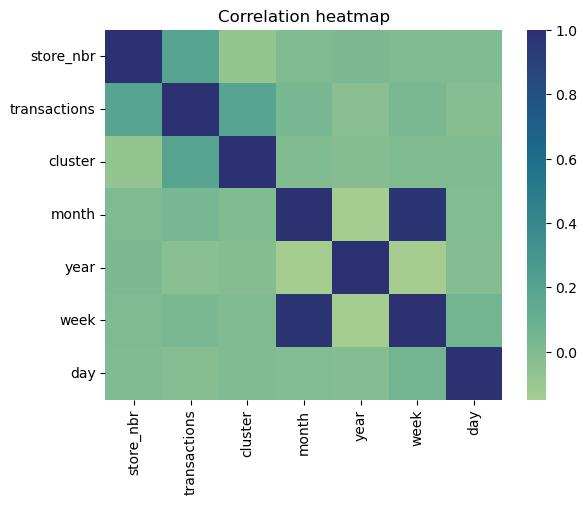

In [9]:
sns.heatmap(data=corr, cmap='crest')
plt.title('Correlation heatmap')

Text(0.5, 1.0, 'Distribution of transactions')

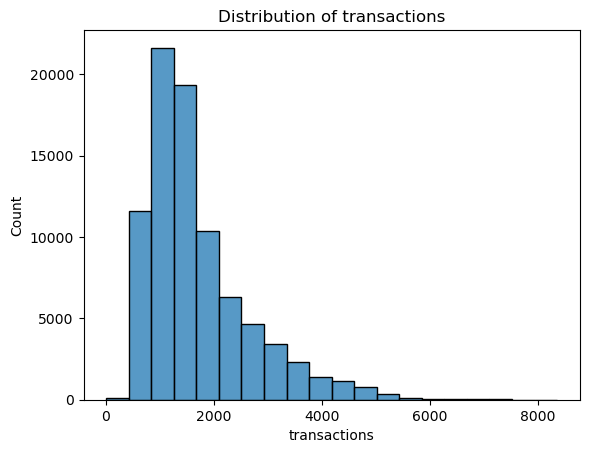

In [10]:
sns.histplot(stores['transactions'], bins=20)
plt.title('Distribution of transactions')

Text(0.5, 1.0, 'Transactions by city')

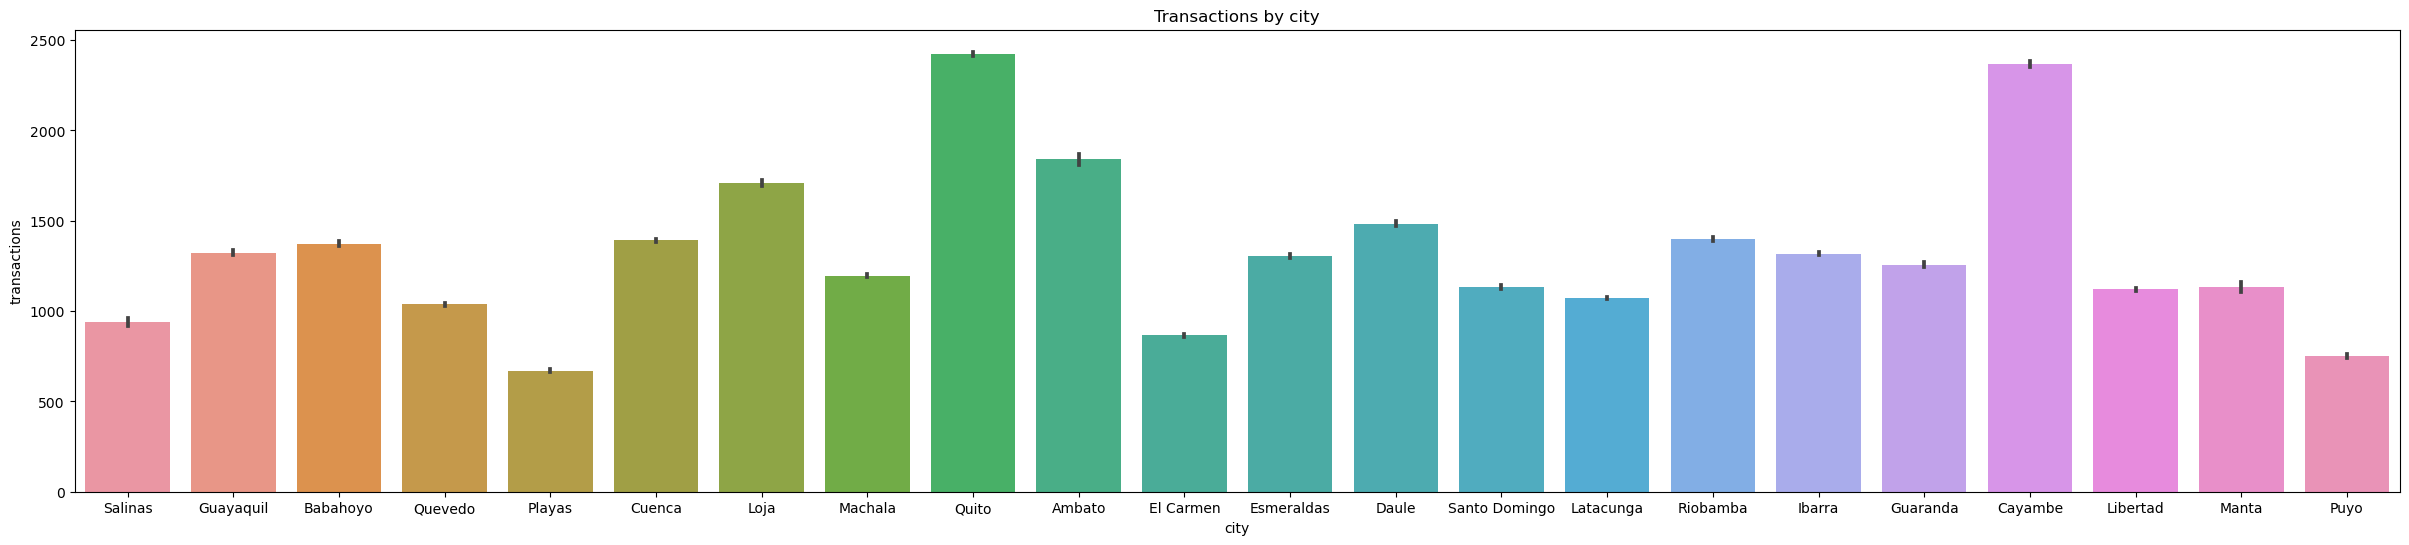

In [11]:
plt.figure(figsize=(30,6))
sns.barplot(data=stores, x='city', y='transactions')
plt.title('Transactions by city')

Text(0.5, 1.0, 'Transaction by state')

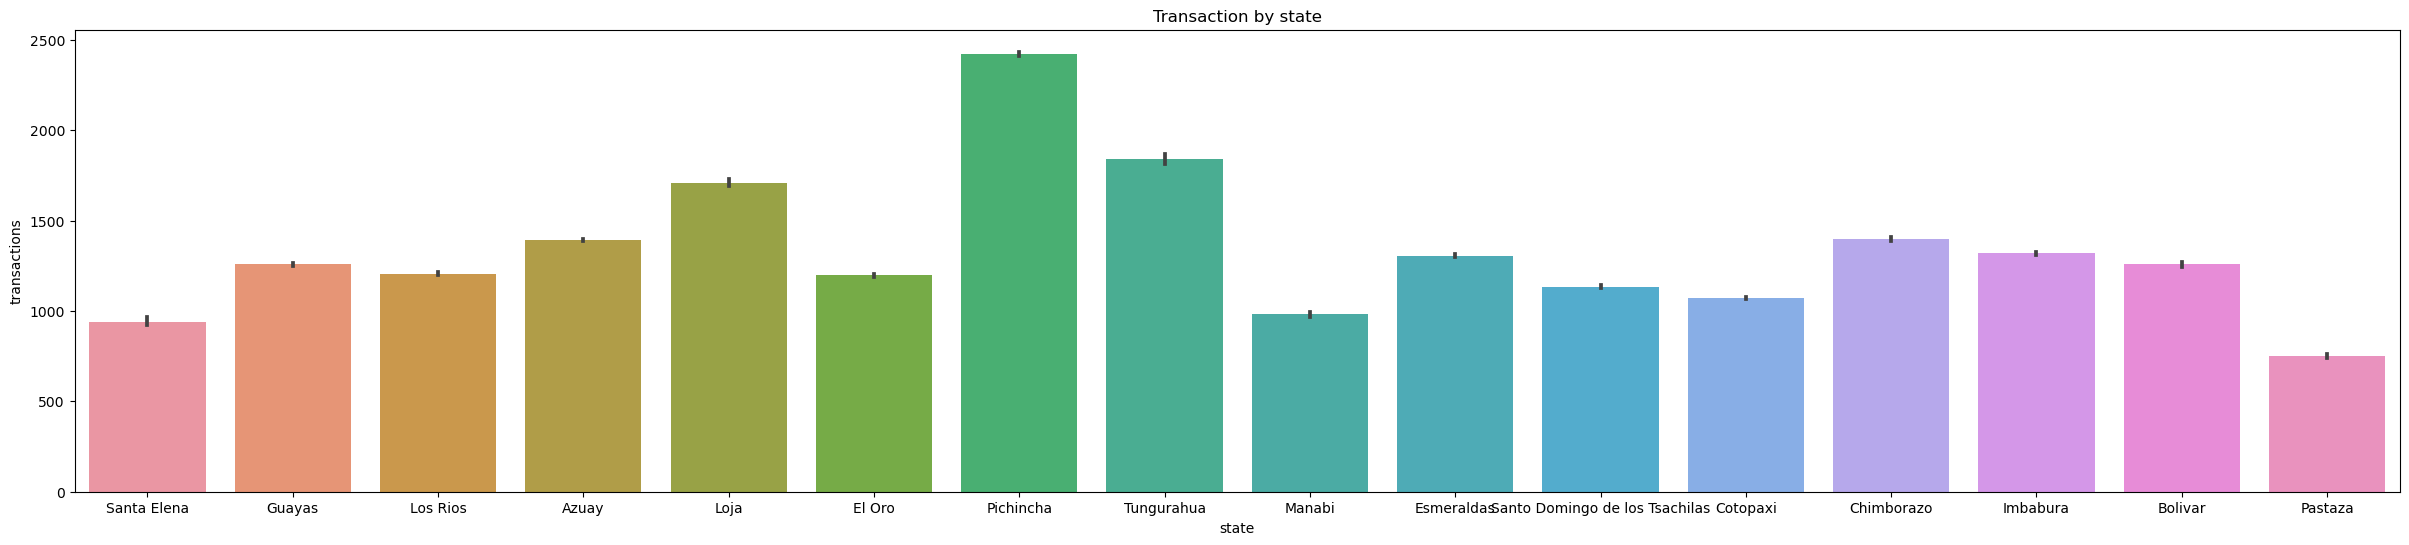

In [12]:
plt.figure(figsize=(30,6))
sns.barplot(data=stores, x='state', y='transactions')
plt.title('Transaction by state')

Text(0.5, 1.0, 'Transaction by year')

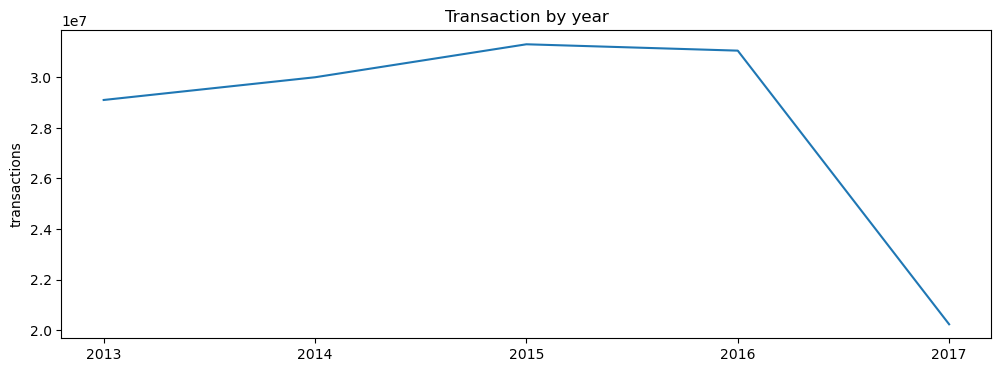

In [13]:
plt.figure(figsize=(12,4))

months = stores.month.unique()

transaction_per_week = stores.groupby('week')['transactions'].sum()
transaction_per_month = stores.groupby('month')['transactions'].sum()
transaction_per_year = stores.groupby('year')['transactions'].sum()

sns.lineplot(x=stores['year'].unique().astype(str), y=transaction_per_year)
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transaction by year')

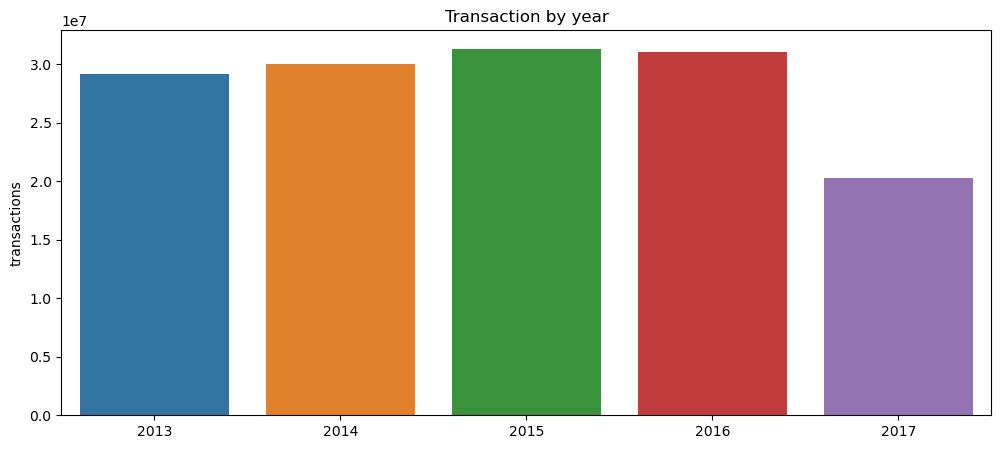

In [14]:
plt.figure(figsize=(12,5))

sns.barplot(x=stores['year'].unique().astype(str), y=transaction_per_year)
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transaction by month')

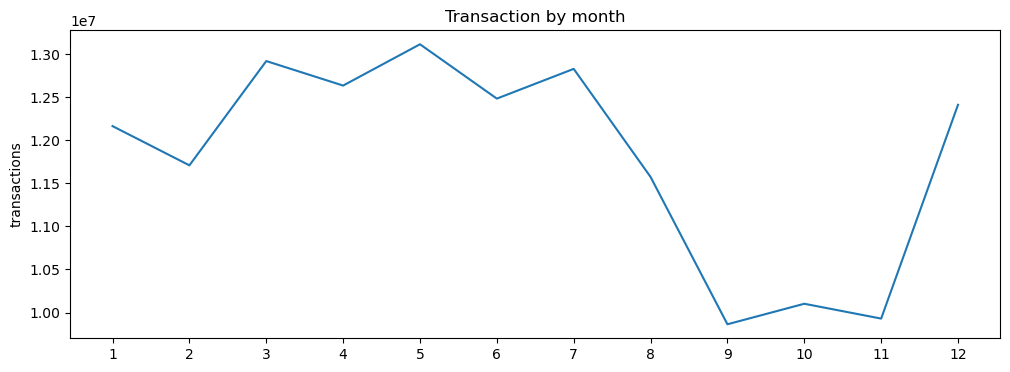

In [15]:
plt.figure(figsize=(12,4))
sns.lineplot(x=stores['month'].unique().astype(str), y=transaction_per_month)
plt.title('Transaction by month')

Text(0.5, 1.0, 'Transaction by month')

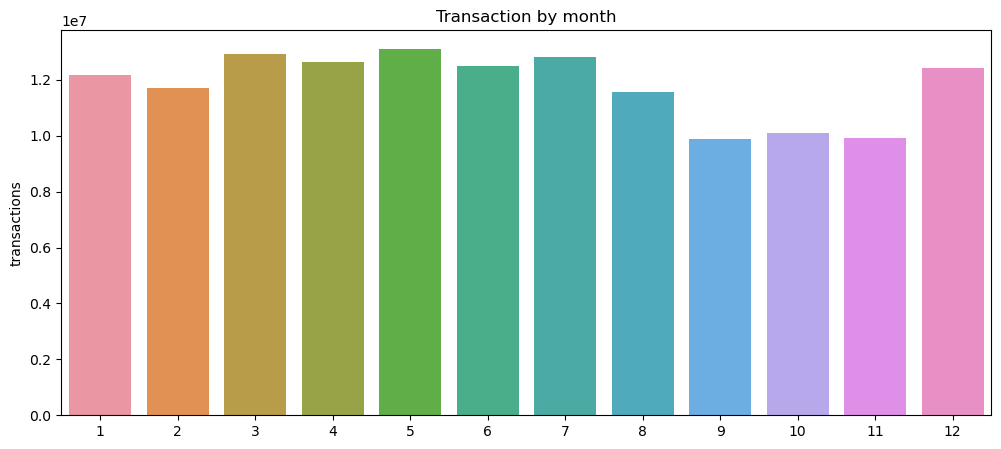

In [16]:
plt.figure(figsize=(12,5))
sns.barplot(x=stores['month'].unique().astype(str), y=transaction_per_month)
plt.title('Transaction by month')

Text(0.5, 1.0, 'Transaction by week')

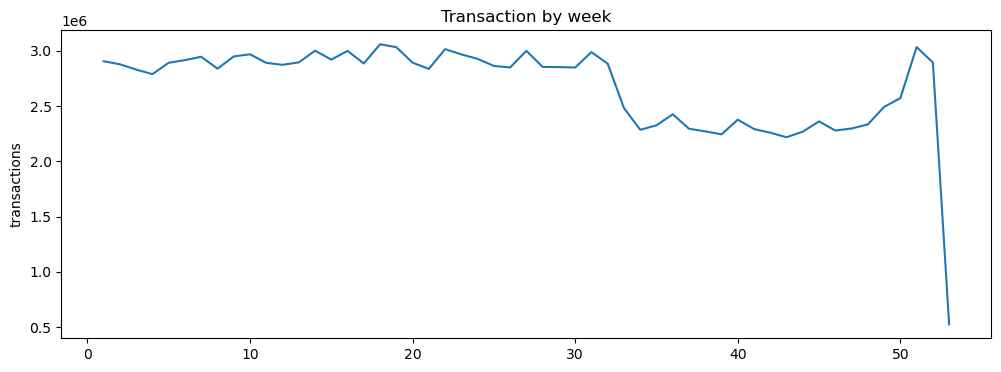

In [17]:
plt.figure(figsize=(12,4))
sns.lineplot(x=stores['week'].unique(), y=transaction_per_week)
plt.title('Transaction by week')

Text(0.5, 1.0, 'Transaction by week')

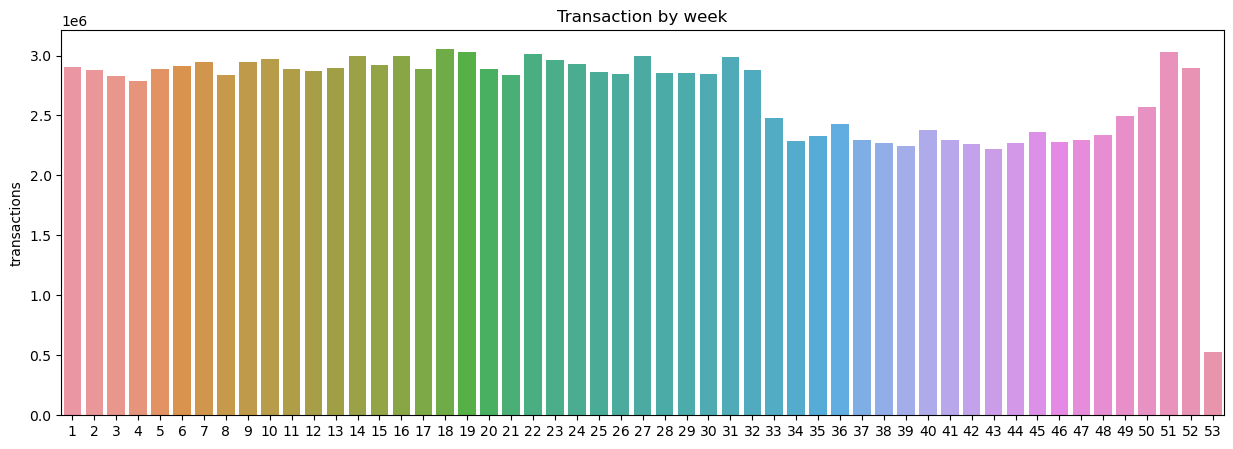

In [18]:
plt.figure(figsize=(15,5))

sns.barplot(x=stores['week'].unique().astype(str), y=transaction_per_week)
plt.title('Transaction by week')

Text(0.5, 1.0, 'Transaction by year')

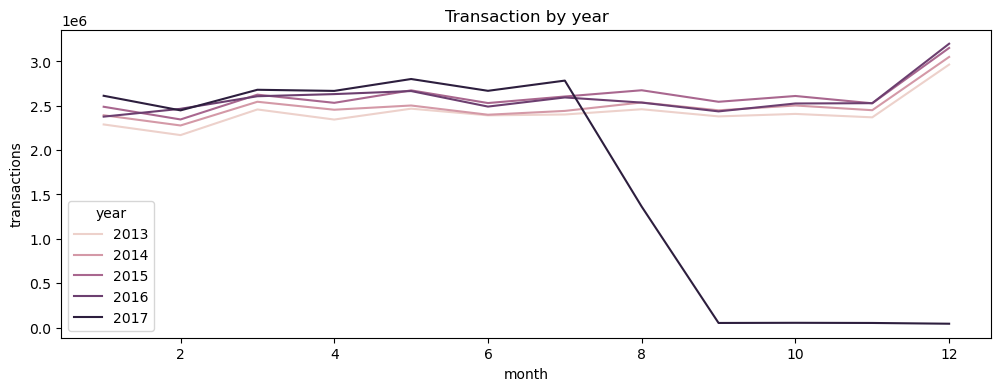

In [19]:
plt.figure(figsize=(12,4))
transactions_per_year = stores.groupby(['year','month'])['transactions'].sum()
transactions_per_year = pd.DataFrame(transactions_per_year)
transactions_per_year = transactions_per_year.reset_index()

sns.lineplot(data=transactions_per_year, x=transactions_per_year['month'], y=transactions_per_year['transactions'],hue=transactions_per_year['year'])
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transactions in 2015')

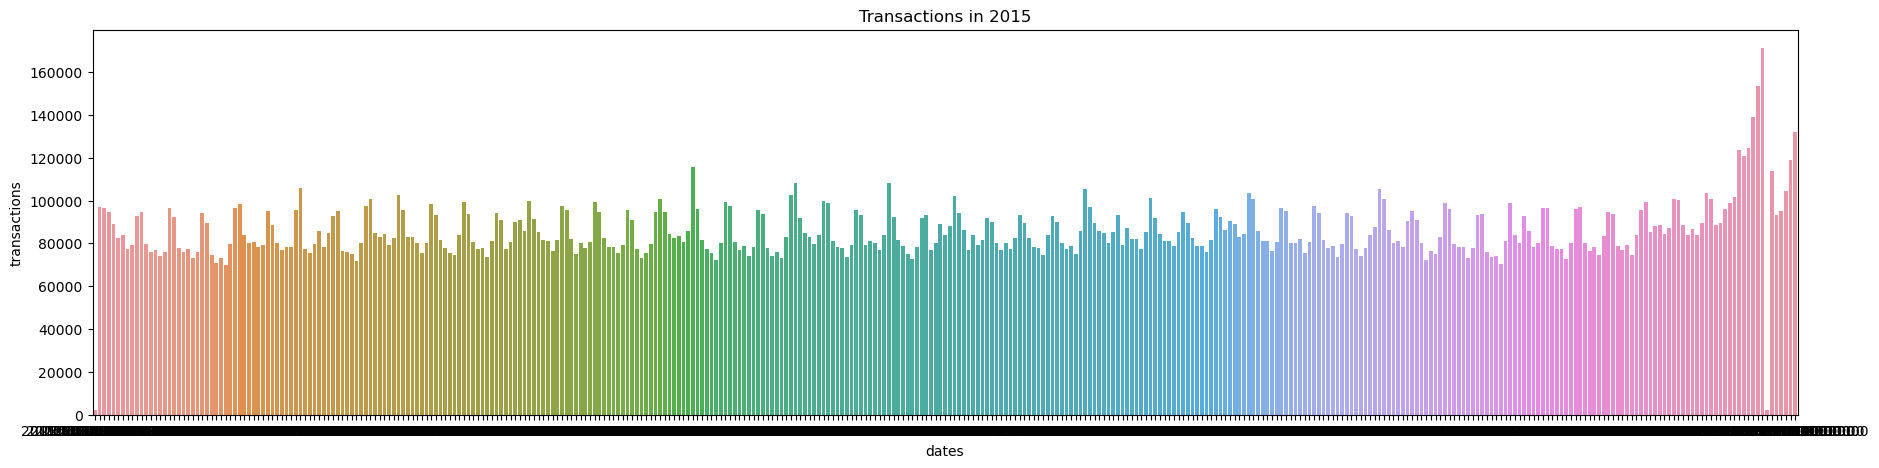

In [20]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2015]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2015')

Text(0.5, 1.0, 'Transactions in 2016')

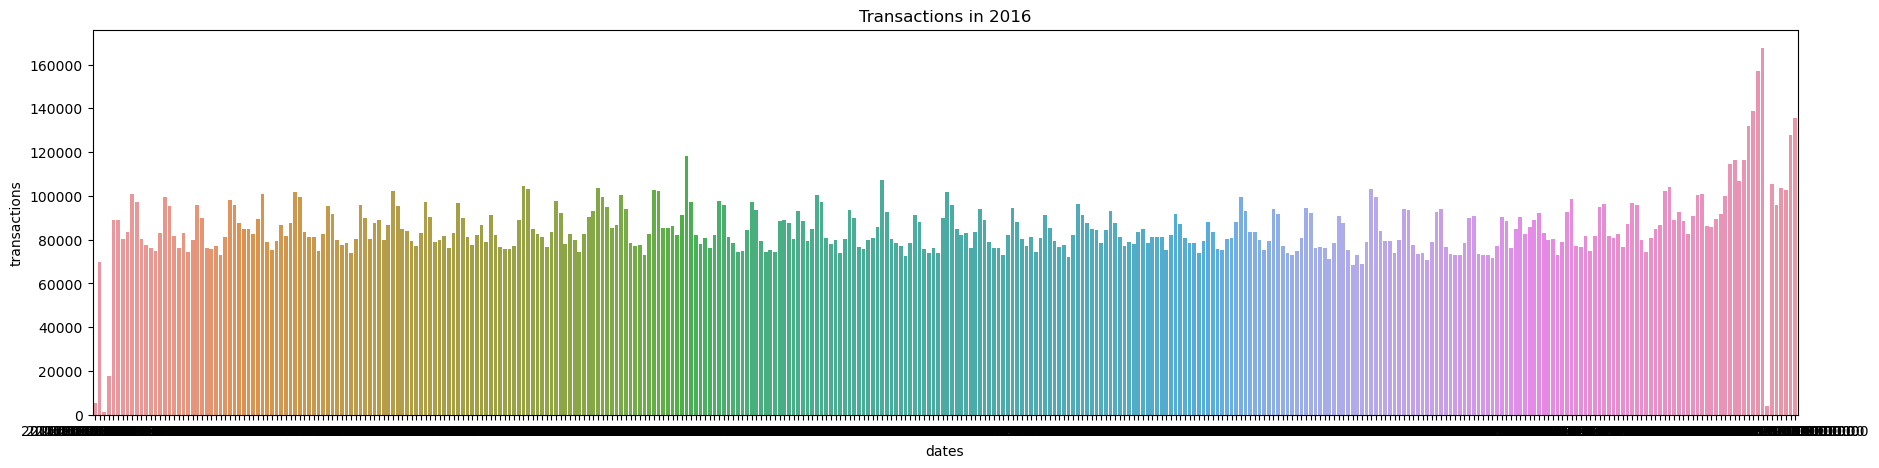

In [21]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2016]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2016')

Text(0.5, 1.0, 'Transactions in 2016')

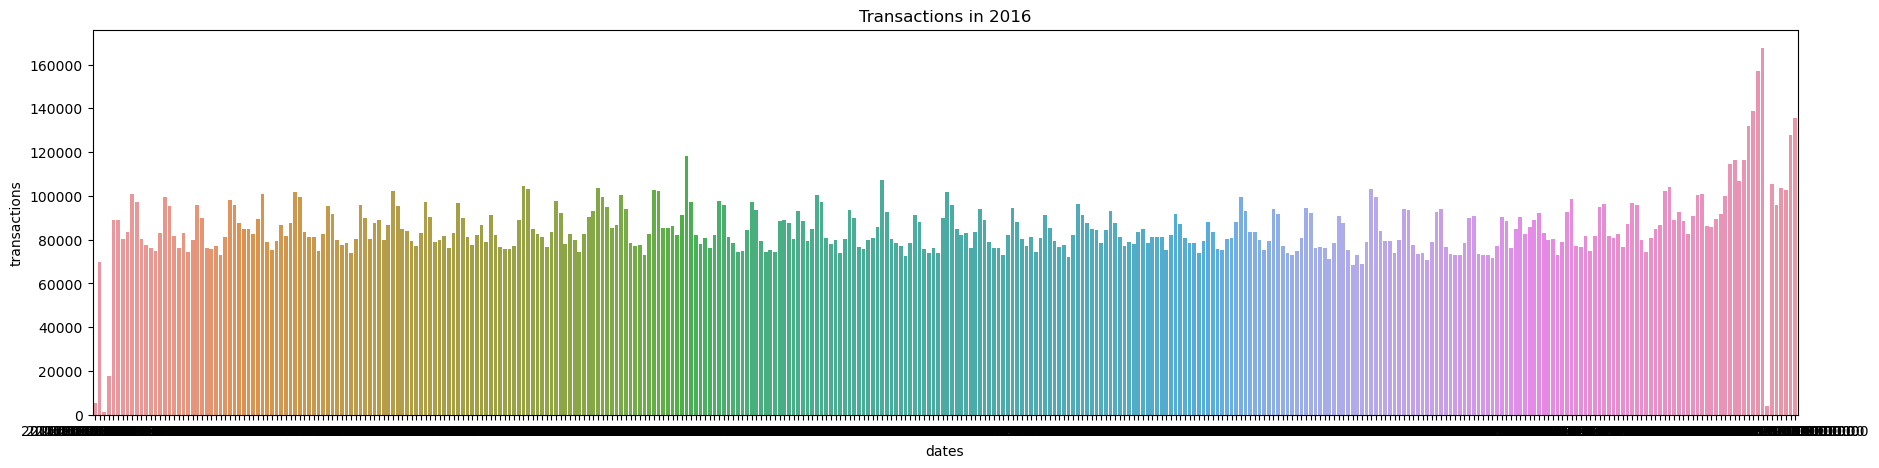

In [22]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2016]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2016')

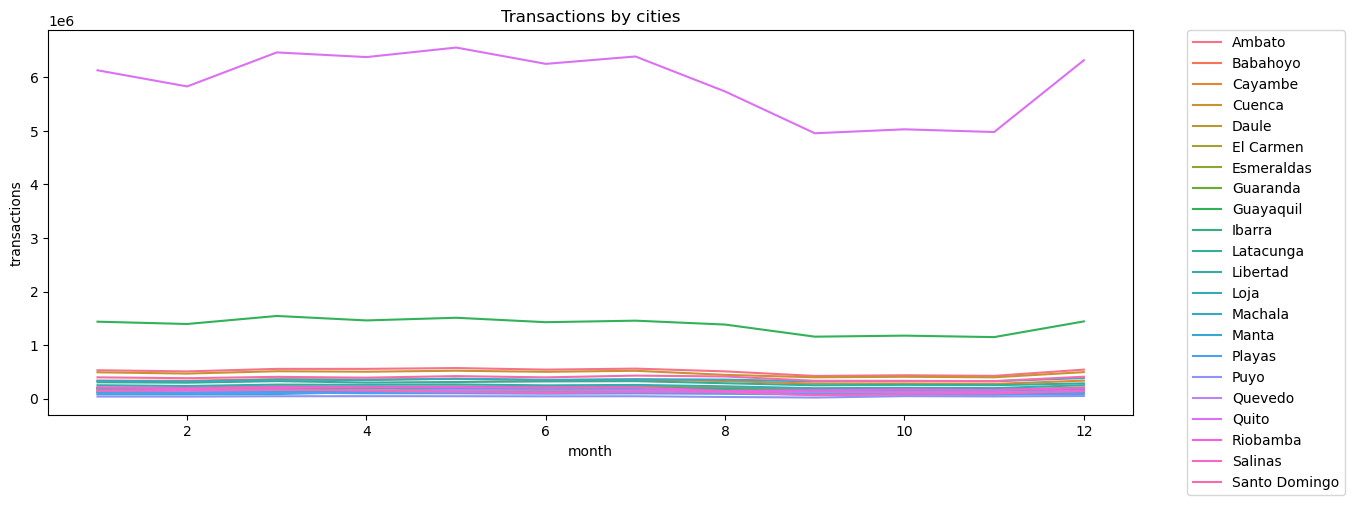

In [23]:
stores['cities'] = stores['city']
city_by_month = stores.groupby(['cities', 'month'])['transactions'].sum()
city_by_month = pd.DataFrame(city_by_month)
city_by_month = city_by_month.reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=city_by_month, x=city_by_month['month'], y=city_by_month['transactions'], hue=city_by_month['cities'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Transactions by cities')
stores = stores.drop('cities', axis=1)

Text(0.5, 1.0, 'Count of transactions by cities')

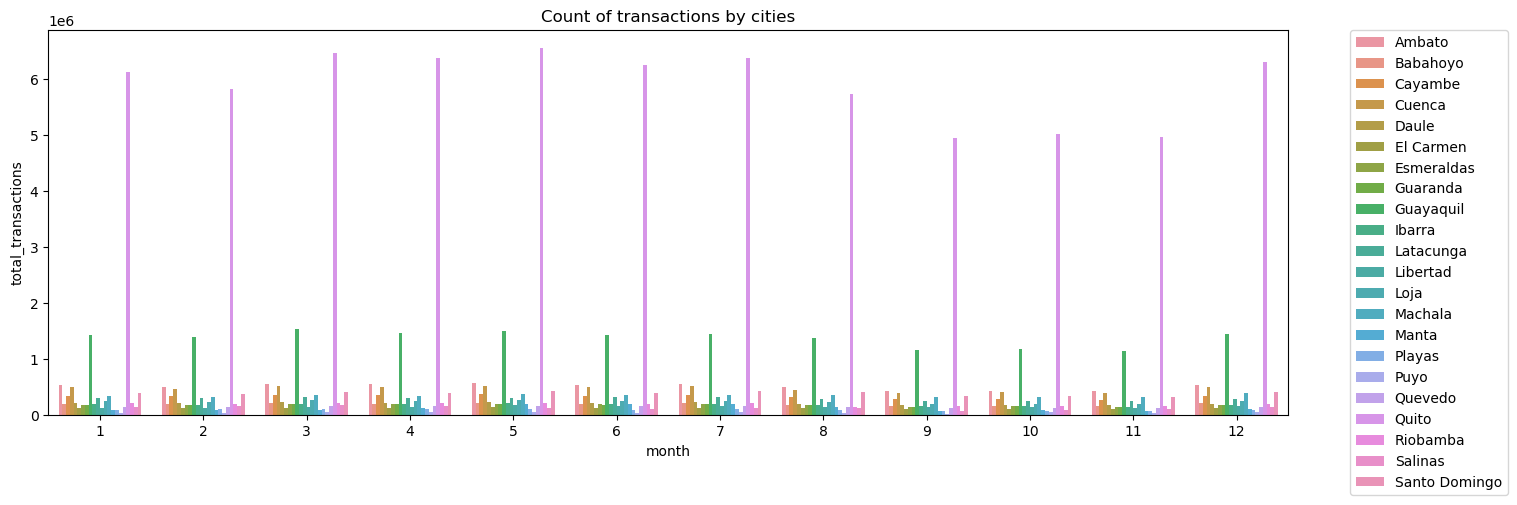

In [24]:
stores['cities'] = stores['city']
city_by_month_count = stores.groupby(['cities', 'month'])['transactions'].count()
city_by_month_count = pd.DataFrame(city_by_month_count)
city_by_month_count = city_by_month_count.reset_index()
city_by_month_count['total_transactions'] = city_by_month['transactions']

plt.figure(figsize=(16,5))
sns.barplot(data=city_by_month_count, x=city_by_month_count['month'], y=city_by_month_count['total_transactions'], hue=city_by_month_count['cities'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Count of transactions by cities')

Text(0.5, 1.0, 'Transactions by type')

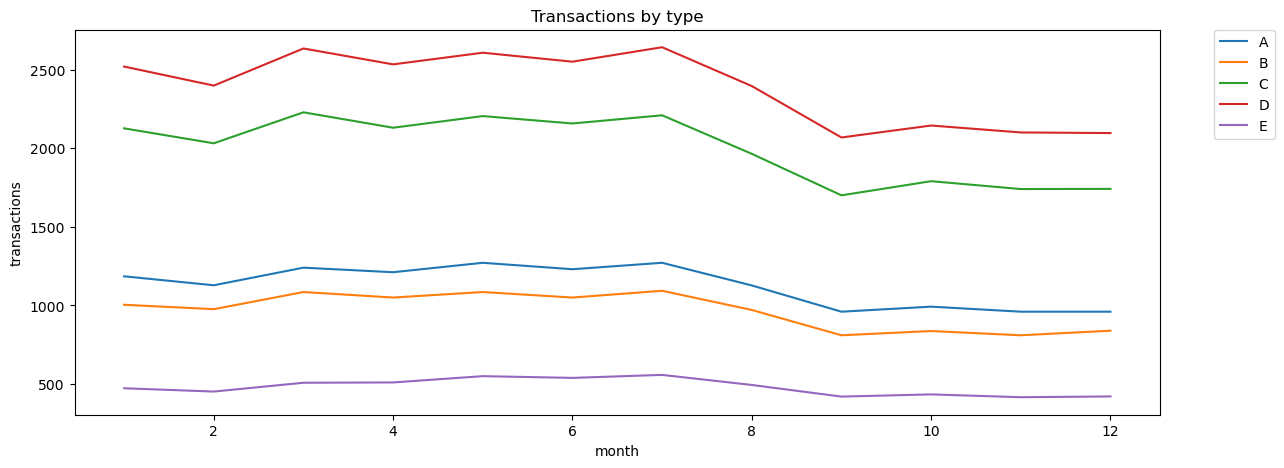

In [25]:
type_by_month = stores.groupby(['type', 'month'])['transactions'].count()
type_by_month = pd.DataFrame(type_by_month)
type_by_month = type_by_month.reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=type_by_month, x=type_by_month['month'], y=type_by_month['transactions'], hue=type_by_month['type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Transactions by type')

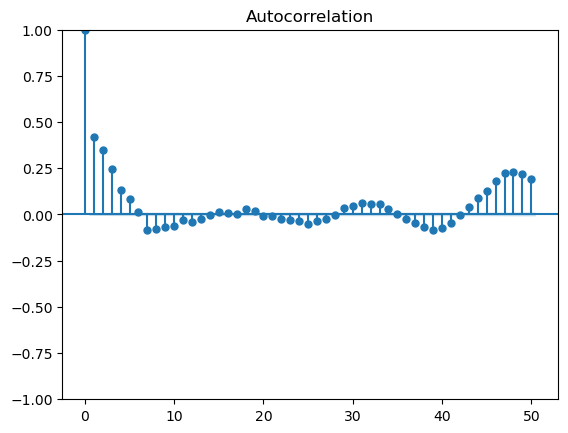

In [26]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

to_plot = pd.DataFrame(stores['transactions'])
to_plot = to_plot.dropna()
acf = plot_acf(to_plot, lags=50)

# Cleaning

In [27]:
target = stores['transactions']
stores = stores.drop('transactions', axis = 1)
stores = stores.drop('store_nbr', axis=1)

stores = pd.concat([target, stores], axis = 1)
stores

,transactions,city,state,type,cluster,month,year,week,day,cities
dates,,,,,,,,,,
2013-01-01,770.000000,Salinas,Santa Elena,D,1.0,1,2013,1,1,Salinas
2013-01-02,708.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2,Guayaquil
2013-01-02,1401.000000,Babahoyo,Los Rios,B,10.0,1,2013,1,2,Babahoyo
2013-01-02,776.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2,Guayaquil
2013-01-02,1163.000000,Quevedo,Los Rios,C,3.0,1,2013,1,2,Quevedo
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,1719.878964,Machala,El Oro,D,4.0,12,2017,51,21,Machala
2017-12-22,1719.878964,Machala,El Oro,D,4.0,12,2017,51,22,Machala
2017-12-23,1719.878964,Machala,El Oro,D,4.0,12,2017,51,23,Machala


In [28]:
target_map = stores['transactions'].to_dict()
stores['lag1'] = (stores.index - pd.Timedelta('364 days')).map(target_map)
stores['lag2'] = (stores.index - pd.Timedelta('728 days')).map(target_map)

In [29]:
city = pd.get_dummies(stores['city'])
types = pd.get_dummies(stores['type'])
cluster = pd.get_dummies(stores['cluster'])

stores = pd.concat([stores, city], axis=1)
stores = pd.concat([stores, types], axis=1)
stores = pd.concat([stores, cluster], axis=1)

stores = stores.drop(['city', 'state', 'type', 'cluster', 'cities'], axis=1)
stores

,transactions,month,year,week,day,lag1,lag2,Ambato,Babahoyo,Cayambe,...,9.5,10.0,11.0,11.5,12.0,13.0,14.0,15.0,16.0,17.0
dates,,,,,,,,,,,,,,,,,,,,,
2013-01-01,770.000000,1,2013,1,1,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,708.000000,1,2013,1,2,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,1401.000000,1,2013,1,2,NaN,NaN,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2013-01-02,776.000000,1,2013,1,2,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-02,1163.000000,1,2013,1,2,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,1719.878964,12,2017,51,21,1828.0,3943.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-22,1719.878964,12,2017,51,22,1805.0,2393.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,1719.878964,12,2017,51,23,2367.0,1379.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
from sklearn.model_selection import train_test_split

y = stores['transactions']

train = stores.loc[stores.index < '2016-12-30']
test = stores.loc[stores.index >= '2016-12-30']
train = train.dropna()
train

,transactions,month,year,week,day,lag1,lag2,Ambato,Babahoyo,Cayambe,...,9.5,10.0,11.0,11.5,12.0,13.0,14.0,15.0,16.0,17.0
dates,,,,,,,,,,,,,,,,,,,,,
2014-12-30,1760.0,12,2014,1,30,1959.0,770.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2014-12-30,2710.0,12,2014,1,30,1959.0,770.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-30,2544.0,12,2014,1,30,1959.0,770.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2014-12-30,785.0,12,2014,1,30,1959.0,770.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-12-30,1868.0,12,2014,1,30,1959.0,770.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29,732.0,12,2016,52,29,5414.0,2202.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-29,1389.0,12,2016,52,29,5414.0,2202.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2016-12-29,1587.0,12,2016,52,29,5414.0,2202.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)


x = train
x_test = test.drop(['transactions'], axis=1)
y_test = test['transactions']
y_test = np.array(y_test)
x = scaler.fit_transform(x)
x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))
train_set = pd.DataFrame(x)
test_set = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test, columns=['True'])
train_set.to_csv("train.csv", header=False, index=False)
test_set.to_csv("validation.csv", header=False, index=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


In [32]:
bucket = sagemaker.Session().default_bucket()
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
bucket

'sagemaker-eu-west-2-866647877267'

In [33]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [518]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=13,
    eta=0.05,
    gamma=1,
    min_child_weight=1,
    subsample=0.5,
    verbosity=0,
    objective="reg:squarederror",
    num_round=600,
)

xgb.fit({"train": s3_input_train, "validation" : s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-03-31-14-25-47-316


2023-03-31 14:25:47 Starting - Starting the training job...
2023-03-31 14:26:14 Starting - Preparing the instances for training......
2023-03-31 14:27:10 Downloading - Downloading input data...
2023-03-31 14:27:35 Training - Downloading the training image......
2023-03-31 14:28:26 Training - Training image download completed. Training in progress.[2023-03-31 14:28:35.276 ip-10-0-128-36.eu-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-31 14:28:35.352 ip-10-0-128-36.eu-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-03-31:14:28:35:INFO] Imported framework sagemaker_xgboost_container.training
[2023-03-31:14:28:35:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2023-03-31:14:28:35:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-31:14:28:35:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-03-31:14:28:35:INFO] Determined 0 

[136]#011train-rmse:0.05076#011validation-rmse:0.25654
[137]#011train-rmse:0.05076#011validation-rmse:0.25655
[138]#011train-rmse:0.05076#011validation-rmse:0.25656
[139]#011train-rmse:0.05076#011validation-rmse:0.25656
[140]#011train-rmse:0.05076#011validation-rmse:0.25656
[141]#011train-rmse:0.05076#011validation-rmse:0.25656
[142]#011train-rmse:0.05076#011validation-rmse:0.25657
[143]#011train-rmse:0.05076#011validation-rmse:0.25657
[144]#011train-rmse:0.05076#011validation-rmse:0.25657
[145]#011train-rmse:0.05076#011validation-rmse:0.25656
[146]#011train-rmse:0.05076#011validation-rmse:0.25657
[147]#011train-rmse:0.05076#011validation-rmse:0.25657
[148]#011train-rmse:0.05076#011validation-rmse:0.25658
[149]#011train-rmse:0.05076#011validation-rmse:0.25658
[150]#011train-rmse:0.05076#011validation-rmse:0.25658
[151]#011train-rmse:0.05076#011validation-rmse:0.25659
[152]#011train-rmse:0.05076#011validation-rmse:0.25659
[153]#011train-rmse:0.05076#011validation-rmse:0.25658
[154]#011t

[276]#011train-rmse:0.05052#011validation-rmse:0.25695
[277]#011train-rmse:0.05052#011validation-rmse:0.25695
[278]#011train-rmse:0.05052#011validation-rmse:0.25695
[279]#011train-rmse:0.05052#011validation-rmse:0.25693
[280]#011train-rmse:0.05052#011validation-rmse:0.25693
[281]#011train-rmse:0.05052#011validation-rmse:0.25693
[282]#011train-rmse:0.05052#011validation-rmse:0.25694
[283]#011train-rmse:0.05052#011validation-rmse:0.25695
[284]#011train-rmse:0.05052#011validation-rmse:0.25694
[285]#011train-rmse:0.05052#011validation-rmse:0.25695
[286]#011train-rmse:0.05052#011validation-rmse:0.25694
[287]#011train-rmse:0.05052#011validation-rmse:0.25695
[288]#011train-rmse:0.05052#011validation-rmse:0.25696
[289]#011train-rmse:0.05052#011validation-rmse:0.25696
[290]#011train-rmse:0.05052#011validation-rmse:0.25697
[291]#011train-rmse:0.05052#011validation-rmse:0.25697
[292]#011train-rmse:0.05052#011validation-rmse:0.25697
[293]#011train-rmse:0.05052#011validation-rmse:0.25697
[294]#011t

[437]#011train-rmse:0.05040#011validation-rmse:0.25688
[438]#011train-rmse:0.05040#011validation-rmse:0.25687
[439]#011train-rmse:0.05040#011validation-rmse:0.25687
[440]#011train-rmse:0.05040#011validation-rmse:0.25686
[441]#011train-rmse:0.05040#011validation-rmse:0.25686
[442]#011train-rmse:0.05040#011validation-rmse:0.25686
[443]#011train-rmse:0.05040#011validation-rmse:0.25686
[444]#011train-rmse:0.05040#011validation-rmse:0.25685
[445]#011train-rmse:0.05040#011validation-rmse:0.25685
[446]#011train-rmse:0.05040#011validation-rmse:0.25685
[447]#011train-rmse:0.05040#011validation-rmse:0.25686
[448]#011train-rmse:0.05040#011validation-rmse:0.25686
[449]#011train-rmse:0.05040#011validation-rmse:0.25687
[450]#011train-rmse:0.05040#011validation-rmse:0.25687
[451]#011train-rmse:0.05040#011validation-rmse:0.25687
[452]#011train-rmse:0.05040#011validation-rmse:0.25686
[453]#011train-rmse:0.05040#011validation-rmse:0.25685
[454]#011train-rmse:0.05040#011validation-rmse:0.25685
[455]#011t


2023-03-31 14:30:18 Uploading - Uploading generated training model
2023-03-31 14:30:18 Completed - Training job completed
Training seconds: 189
Billable seconds: 189


In [532]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

n_jobs = 150
n_parallel_jobs = 10

hpt_ranges = {
    #'alpha': ContinuousParameter(.01, .5),
    'eta': ContinuousParameter(.01, .5),
    'min_child_weight': ContinuousParameter(0., 2.),
    'subsample' : ContinuousParameter(.3,1),
    'gamma' : ContinuousParameter(0., 1),
    'num_round' : IntegerParameter(100, 1200),
    'max_depth' : IntegerParameter(3, 15)
}

tuner_parameters = {
    'estimator': xgb, # The same estimator object we defined above
    'base_tuning_job_name': 'bayesian',
    'objective_metric_name': 'validation:rmse',
    'objective_type': 'Minimize',
    'hyperparameter_ranges': hpt_ranges,
    'strategy': 'Bayesian',
    'max_jobs': n_jobs,
    'max_parallel_jobs': n_parallel_jobs
}



In [533]:
tuner = HyperparameterTuner(**tuner_parameters)
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, wait=False)
tuner_name = tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {tuner_name}.')

INFO:sagemaker:Creating hyperparameter tuning job with name: bayesian-230331-1524


tuning job submitted: bayesian-230331-1524.


In [242]:
tuner.describe()['BestTrainingJob']

{'TrainingJobName': 'bayesian-230331-1216-001-eecdc300',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-2:866647877267:training-job/bayesian-230331-1216-001-eecdc300',
 'CreationTime': datetime.datetime(2023, 3, 31, 12, 16, 19, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2023, 3, 31, 12, 17, 35, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2023, 3, 31, 12, 19, 52, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'alpha': '0.05474975856822754',
  'eta': '0.49221101464139205',
  'gamma': '3.466979733627687',
  'max_depth': '3',
  'min_child_weight': '1.822765629500063',
  'num_round': '708',
  'subsample': '0.9267610845367645'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:rmse',
  'Value': 0.2540600001811981},
 'ObjectiveStatus': 'Succeeded'}

In [244]:
tuned_predictor = tuner.deploy(initial_instance_count=1,
                              instance_type = 'ml.m4.xlarge')


2023-03-31 12:19:54 Starting - Preparing the instances for training
2023-03-31 12:19:54 Downloading - Downloading input data
2023-03-31 12:19:54 Training - Training image download completed. Training in progress.
2023-03-31 12:19:54 Uploading - Uploading generated training model
2023-03-31 12:19:54 Completed - Resource retained for reuse

INFO:sagemaker:Creating model with name: bayesian-2023-03-31-12-31-16-337


INFO:sagemaker:Creating endpoint-config with name bayesian-230331-1216-001-eecdc300
INFO:sagemaker:Creating endpoint with name bayesian-230331-1216-001-eecdc300


------!

In [247]:
tuned_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [54]:
model_data = 's3://sagemaker-eu-west-2-866647877267/Datasets/output/bayesian-230331-1524-149-01195598/output/model.tar.gz'

In [56]:
sm_model = sagemaker.Model(model_data=model_data, image_uri=container, role=role, sagemaker_session=sess)
sm_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

------!

In [36]:
sm_model.endpoint_name

NameError: name 'sm_model' is not defined

In [37]:
endpoint_name = 'sagemaker-xgboost-2023-03-31-23-10-16-323'

In [38]:
predictor = sagemaker.Predictor(endpoint_name= endpoint_name)

In [39]:
predictor.serializer = sagemaker.serializers.CSVSerializer()

In [42]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, predictor.predict(array).decode("utf-8")])
    return predictions.split("\n")[:-1]

test_set = np.array(test_set)
predictions = predict(test_set)
preds = predictions


preds = [float(i) for i in preds]

y_test['predicted'] = preds

In [43]:
predicted = np.array(y_test['predicted']).reshape(-1,1)
true = np.array(y_test['True']).reshape(-1,1)
predicted = scaler.inverse_transform(predicted)
true = scaler.inverse_transform(true)
result = pd.DataFrame(y_test)
result['predicted'] = predicted
result['True'] = true

result

,True,predicted
0,1773.000000,1000.763100
1,5798.000000,3368.781327
2,6360.000000,3843.979601
3,1719.000000,1267.474457
4,1791.000000,1420.970580
...,...,...
12330,1719.878964,1267.474457
12331,1719.878964,1267.474457
12332,1719.878964,1267.474457
12333,1719.878964,1267.474457


In [75]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

mape = mean_absolute_percentage_error(result['True'], result['predicted'])
mae = mean_absolute_error(result['True'], result['predicted'])

print("The mean absolute percentage error is {}".format(round(mape, 2)))
print("The mean absolute error is {}".format(round(mae, 2)))

The mean absolute percentage error is 0.24
The mean absolute error is 423.6


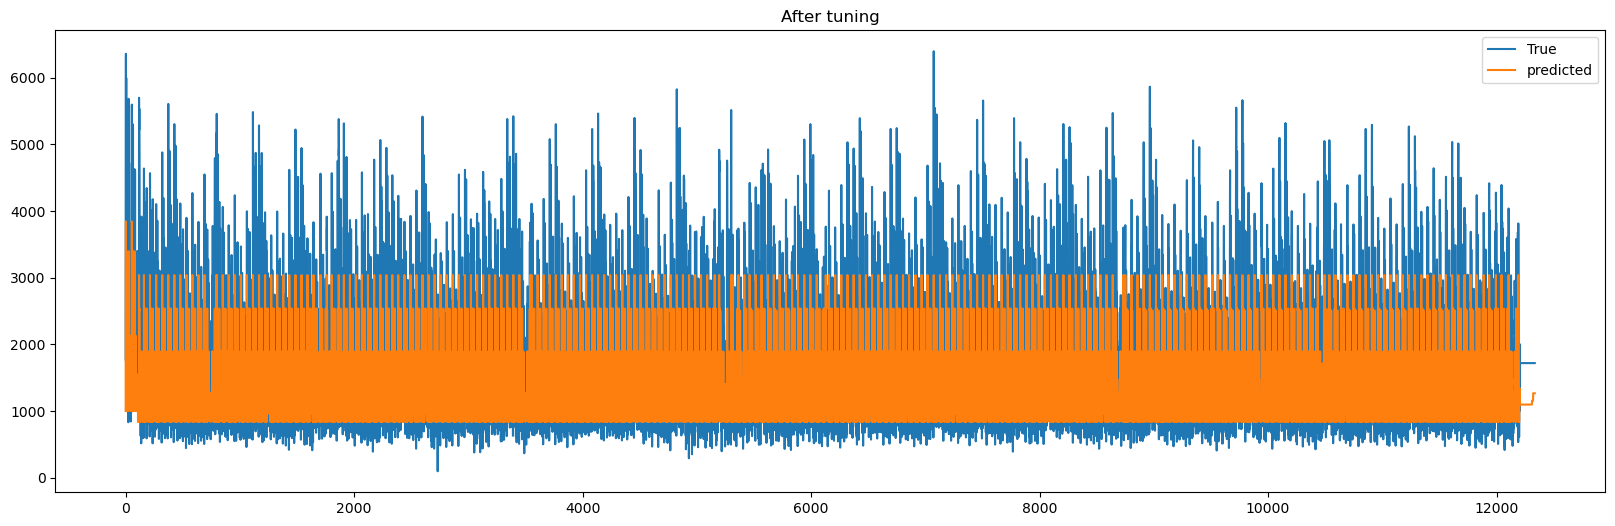

In [53]:
plt.figure(figsize=(20,6))
plt.plot(result['True'], label='True')
plt.plot(result['predicted'], label='predicted')
plt.legend()
plt.title('After tuning')
plt.show()

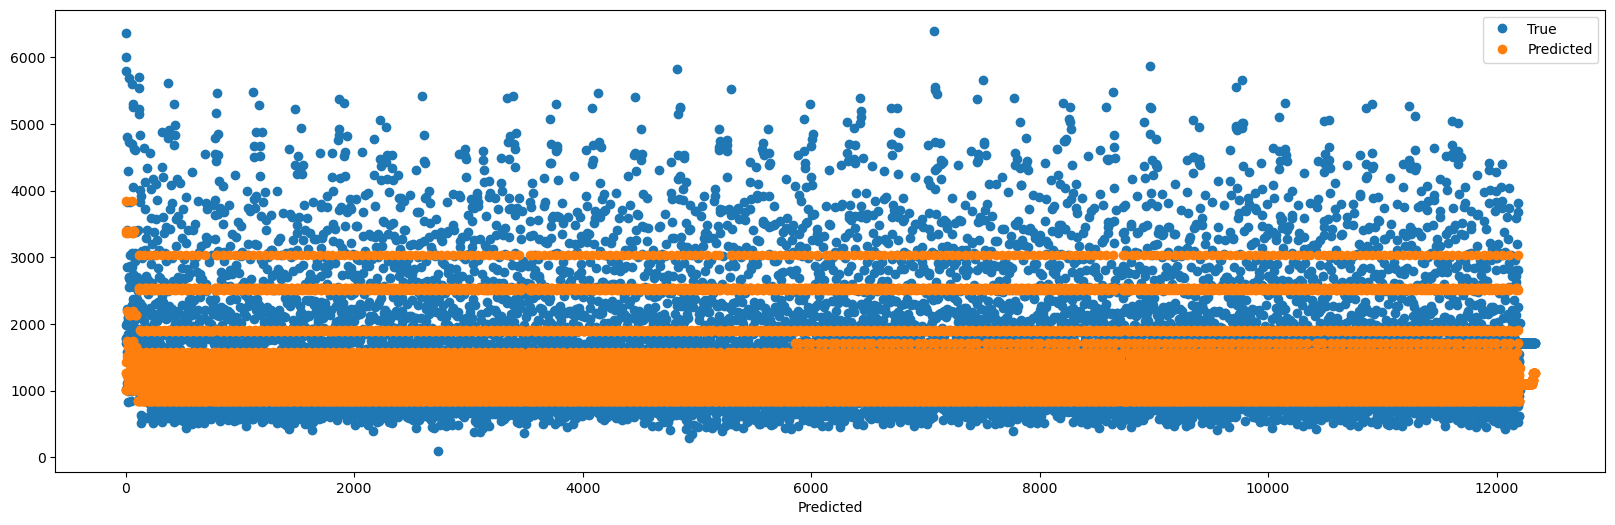

In [70]:
plt.figure(figsize=(20,6))

plt.plot(result['True'], 'o', label='True')
plt.plot(result['predicted'], 'o', label='Predicted')
plt.xlabel('True')
plt.xlabel('Predicted')
plt.legend(loc="upper right")
plt.show()